# Unit 4. RDS. Кредитный рейтинг.

Проект, выполенный в рамках Юнита 4. Проект 4. Компьютер говорит "Нет"

Исполнитель: Николай Михельсон (dst-40)

Score: 0.73796 (после отправки файла в соревнование)

## Задание.
Необходимо предсказать надёжность заёмщика для принятия решения о  выдаче кредина на основе данных из БКИ и анкет заёмщиков.

Предсказание проводим методами Машинного обучения (Логистической регрессией). 

## 1. загрузка библиотек и настойки

In [1]:
# загрузка библиотек

import os

from datetime import date
import datetime

import pandas as pd
import numpy as np

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures

from sklearn import metrics
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from itertools import combinations
from scipy.stats import ttest_ind

import warnings

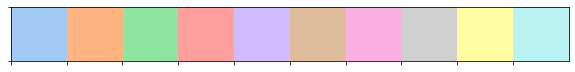

In [2]:
# настройки

warnings.filterwarnings("ignore")  # Убирает некритические сообщения

# показывать больше строк и столбцов данных pandas
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None 

# вывод графика как обычшую картинку в юпитере под ячейкой
%matplotlib inline
sns.color_palette("pastel")  # палитра
# sns.palplot(sns.color_palette(['#50248f', '#38d1ff']))
sns.palplot(sns.color_palette("pastel"))

In [3]:
# фиксируем генератор случайных чисел для воспроиводимости результата
RANDOM_SEED = 42

!pip freeze > requirements.txt

## 2. Определение функций

In [4]:
# Вспомогательная функция для расчета и визуализации границ выбросов.

def show_IQR(pd_dataset, column_name, bins_n=10, feature_name=None , pd_train=None):
    """ 
       Вспомогательная функция для расчета и визуализации границ выбросов.
       на входе датасет, наименование столбца (признака) и количество столбиков гистограмы
       
       Выводит расчитанные параметры квантилей и гистограммы распределения и boxplot
    """
    data_column = pd_dataset[column_name]
    perc_25 = data_column.quantile(0.25, interpolation="midpoint")
    perc_75 = data_column.quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print(f'Q1: {perc_25}\nQ3: {perc_75}\nIQR: {IQR}',
          f'\nГраница выбросов: [{perc_25 - 1.5*IQR}, {perc_75 + 1.5*IQR}]')
    print("Пропущено значений:", data_column.isna().sum())
    
    # гистограмма распределения: 
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.distplot(data_column.values, bins=bins_n, color='#50248f')
    plt.title(column_name + ' Distribution - full dataset\n', fontsize=15)
    plt.xlabel(column_name)
    plt.ylabel('Quantity (frequency)')

    # boxplot: 
    plt.subplot(122)
    sns.boxplot(data_column.values, color='#38d1ff')  # x=train.default, y=train.score_bki
    # sns.boxplot(y=pd_dataset[column_name], x=data_column.values, color='#38d1ff')  # x=train.default, y=train.score_bki
    plt.title(column_name + ' Distribution - full dataset\n', fontsize=15)
    plt.xlabel(column_name)
    plt.show()
    
    if feature_name is not None:
        
        # гистограмма распределения: 
        plt.figure(figsize=(15, 4))
        plt.subplot(121)
        sns.distplot(np.log(data_column.values+1), bins=bins_n, color='#a1c9e0')
        plt.title(' логарифм от ' + column_name, fontsize=15)
        plt.xlabel(column_name)
        plt.ylabel('Quantity (frequency)')
        
        # boxplot: распределение признака по целевой переменной
        plt.subplot(122)
        sns.boxplot(x=pd_train[feature_name], y=pd_train[column_name])
        plt.title(column_name + ' distribution by ' + feature_name, fontsize=15)
        plt.xlabel(feature_name)
        plt.ylabel(column_name)
        
        plt.show()
    return ''


def get_stat_dif(dataset, column, key_column):
    """
        вспомогательная функция для выявления статистически значимой зависимости
        в наборе данных dataset между измерением column и целевым набором key_column
    """
    cols = dataset.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(dataset.loc[dataset.loc[:, column] == comb[0], key_column],
                     dataset.loc[dataset.loc[:, column] == comb[1], key_column]).pvalue \
                <= 0.05/len(combinations_all):
            print('обнаружена статистическая значимость измерения: ', column)
            break

            
def roc_auc_plot(y_valid, y_pred_probs):
    """
        вспомогательная функция построения графика ROC_AUC
    """
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc


def confusion_matrix_plot(y_valid, y_pred):
    """
        вспомогательная функция визуализации confusion matrix
    """
    conf_m = confusion_matrix(y_valid, y_pred)
    conf_m_displ = ConfusionMatrixDisplay(conf_m, display_labels=['1','0'])
    conf_m_displ.plot()
    

def scaler_column(dataset, column):
    """
        Вспомогательная функция для выполнения StandardScaler().fit().transform()
        столбца column в наборе данных df
    """
    scaler = StandardScaler()
    scaler.fit(dataset[[column]])
    return scaler.transform(dataset[[column]])



def show_metrics(y_valid, y_pred, y_pred_proba):
    accuracy = round(accuracy_score(y_valid, y_pred), 3)
    precision = round(precision_score(y_valid, y_pred), 3)
    recall = round(recall_score(y_valid, y_pred), 3)
    f1 = round(f1_score(y_valid, y_pred), 3)
    roc_auc = round(roc_auc_score(y_valid, y_pred_proba), 3)
    print('accuracy score = ', accuracy)
    print('precision score = ', precision)
    print('recall score = ', recall)
    print('f1 score = ', f1)
    print('roc auc score = ', roc_auc)
    return accuracy, precision, recall, f1, roc_auc

## 3. Загрузка набора данных

In [5]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

df_train = pd.read_csv('train_4.csv')
df_test = pd.read_csv('test_4.csv')
df_sample_submission = pd.read_csv('sample_submission_4.csv')

# PATH_to_file = '/kaggle/input/sf-dst-scoring/'
# df_train = pd.read_csv(PATH_to_file+'train.csv')
# df_test = pd.read_csv(PATH_to_file+'test.csv')

In [6]:
print('--- набор данных для обучения ---\nshape=', df_train.shape)
display(df_train.sample(5))
print('--- набор данных для тестирования ---\nshape=', df_test.shape)
display(df_test.sample(5))

--- набор данных для обучения ---
shape= (73799, 19)


client_id   app_date education sex  age car car_type  decline_app_cnt  \
61299      47704  24FEB2014       GRD   M   41   N        N                0   
44984      96240  12APR2014       SCH   F   48   N        N                0   
42831      21926  29JAN2014       GRD   M   30   Y        N                0   
142        72505  20MAR2014       SCH   F   54   N        N                0   
4582       33375  10FEB2014       SCH   F   34   Y        Y                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
61299          0  -1.154124                6             70             2   
44984          1  -2.013515                2             80             2   
42831          0  -2.353052                0             70             1   
142            0  -2.530089                0             40             1   
4582           0  -1.838784                2             40             1   

       work_address  income  sna  first_time foreign_passport  default  
61299             3   50000    1           3                N        0  
44984             3   28000    1           4                N        0  
42831             1   50000    1           2                N        0  
142               1   15000    1           3                N        0  
4582              2   35000    3           2                N        0

--- набор данных для тестирования ---
shape= (36349, 18)


client_id   app_date education sex  age car car_type  decline_app_cnt  \
33419     108930  29APR2014       GRD   M   34   Y        N                0   
30241     106704  25APR2014       GRD   F   41   Y        N                0   
3704       98420  15APR2014       UGR   M   23   N        N                0   
26688     109266  29APR2014       GRD   M   33   Y        Y                0   
7897       43506  20FEB2014       UGR   M   28   Y        Y                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
33419          0  -2.212752                0             60             1   
30241          0  -1.803326                0             70             1   
3704           1  -2.879702                0             80             2   
26688          1  -1.308003                0             50             2   
7897           0  -2.012519                0             50             1   

       work_address  income  sna  first_time foreign_passport  
33419             2   40000    1           3                N  
30241             2  100000    1           4                Y  
3704              3   50000    2           3                N  
26688             3  250000    2           2                Y  
7897              2   35000    1           2                N

Описания полей набора данных

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [7]:
# добавим признак, чтобы было можно определить из какого датасета наблюдение
df_train["is_train"] = True
df_test["is_train"] = False

# т.к. в тестовом датасете нет целевого признака, добавим его и заполним -1
df_test["default"] = -1

# объединим оба датасета в один для удобства построения графиков и заполнения пропусков
df = pd.concat([df_train, df_test], ignore_index=True)

## 4. Первичный анализ набора данных

In [8]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Предварительные наблюдения: 

* 110148 строк, в т.ч. 73799 строк в наборе для обучения и 36349 строк в наборе для тестирования
* дублирующиеся строки не обнаружены
* Education содержит пропуски
* 7 числовых переменных, 10 категориальных и 3 поля Boolean (включая целевую переменную и признак набора для обечения/теста)
* ни у одного из полей нет большой корреляции с целевой переменной
* есть значимая корреляция между Доходом заёмщика и рейтингом региона

## 5. EDA & Feature Engineering

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [10]:
num_cols = ['age', 'decline_app_cnt',
           'bki_request_cnt', 'score_bki', 'income']
cat_cols = ['education', 'region_rating', 'home_address',
           'work_address', 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
date_cols = ['app_date']

Поле client_id не информативно для нашей модели, на него не смотрим. 

### анализируем целевую переменную

default - флаг дефолта по кредиту

In [11]:
# посмотрим пропуски
df['default'].isnull().sum()

0

пропусков в целевой переменной нет.

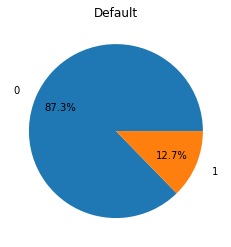

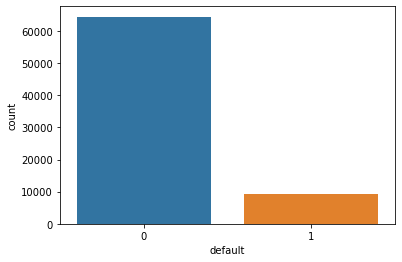

In [12]:
default_ds = df_train['default'].value_counts()
default_lbl = list(df_train['default'].value_counts().index)

plt.pie(default_ds, labels=default_lbl, autopct='%1.1f%%', pctdistance=0.7, labeldistance=1.2)

plt.title('Default')
plt.show()
sns.countplot(df_train['default'])

у 87% заёмщиков нулевой признак дефолта и у 12% положительный.

### пропуски значений

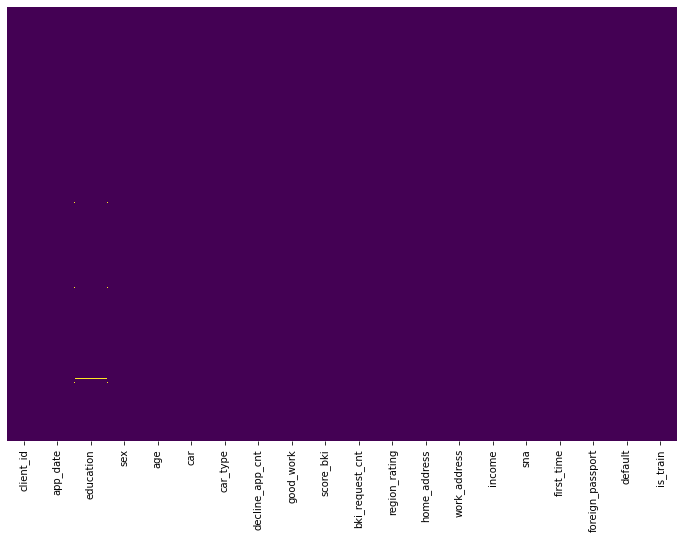

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
sns_heatmap = sns.heatmap(df.isnull(),
                          yticklabels=False,
                          cbar=False,
                          cmap='viridis')

In [14]:
df.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
is_train              0
dtype: int64

Пропуски есть только в поле "education", пропущено 478 строк или менее одного процента набора данных.
Заполним пропуски ниже, после более глубокого анализа.

### app_date
дата, которую надо преобразовать из строкового формата в удобный для работы формат

In [15]:
# форматируем дату из строки в формат datetime
df["app_date"] = pd.to_datetime(df["app_date"])
print('минимальная дата:', min(df["app_date"]), '\nмаксимальная дата:',max(df["app_date"]))

df["app_date"].sample(3)

минимальная дата: 2014-01-01 00:00:00 
максимальная дата: 2014-04-30 00:00:00


71842   2014-03-30
47914   2014-01-30
11381   2014-04-16
Name: app_date, dtype: datetime64[ns]

In [16]:
# даты только с января по апрель 2014, создадим новые признаки: 
# количество дней с первого января 2014 и день недели (вдруг выяснится, что по пятницам больше отказников)

df["app_weekday"] = df["app_date"].dt.weekday
df["app_passed_days"] = (df["app_date"] - datetime.datetime(2014, 1, 1)).dt.days

In [17]:
# распределим новые признаки к числовым переменным
num_cols.extend(["app_weekday", "app_passed_days"])

### рассмотрим численные признаки

In [18]:
print(num_cols)

['age', 'decline_app_cnt', 'bki_request_cnt', 'score_bki', 'income', 'app_weekday', 'app_passed_days']


Q1: 30.0
Q3: 48.0
IQR: 18.0 
Граница выбросов: [3.0, 75.0]
Пропущено значений: 0


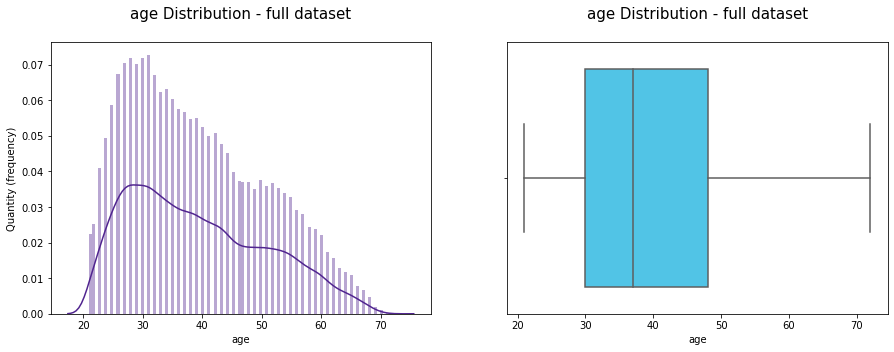

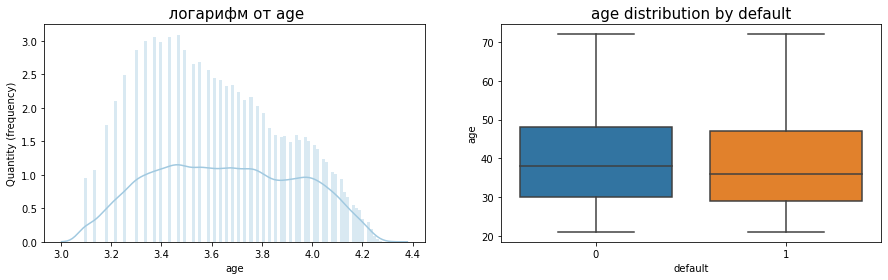

''

In [19]:
show_IQR(df, 'age', 100, 'default', df_train)

Q1: 0.0
Q3: 0.0
IQR: 0.0 
Граница выбросов: [0.0, 0.0]
Пропущено значений: 0


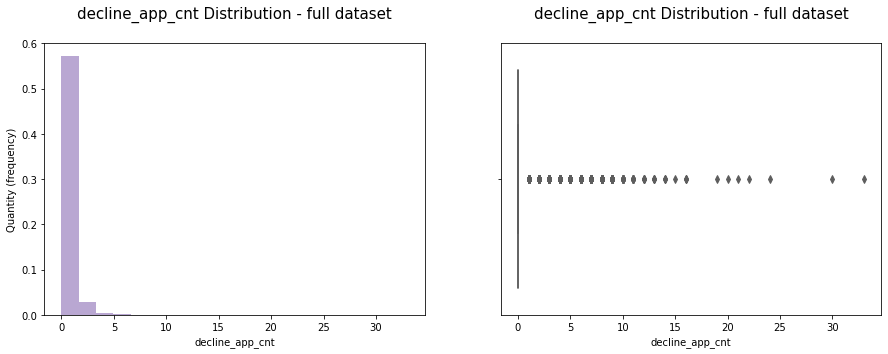

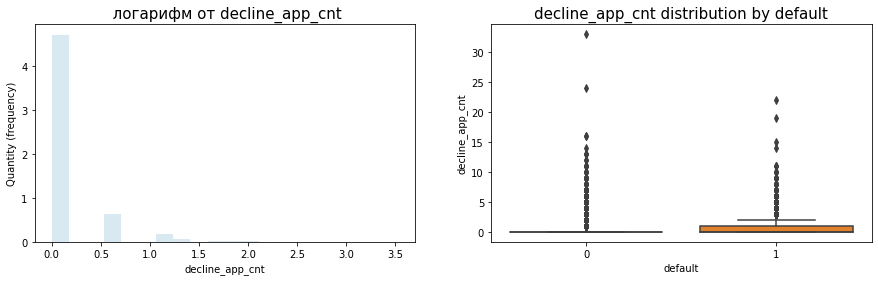

''

In [20]:
show_IQR(df, 'decline_app_cnt', 20, 'default', df_train)
# sns.boxplot(x=df_train['default'], y=df_train['decline_app_cnt'])

Q1: 0.0
Q3: 3.0
IQR: 3.0 
Граница выбросов: [-4.5, 7.5]
Пропущено значений: 0


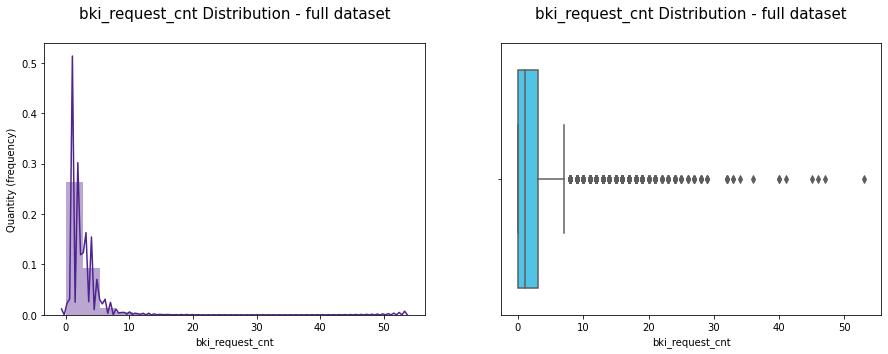

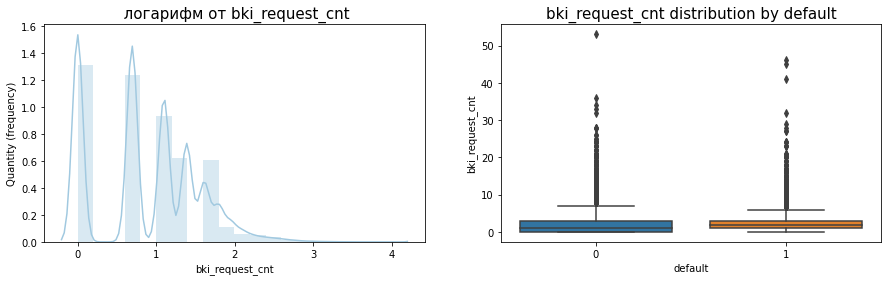

''

In [21]:
show_IQR(df, 'bki_request_cnt', 20, 'default', df_train)

Q1: -2.26044074
Q3: -1.5678840649999999
IQR: 0.6925566750000001 
Граница выбросов: [-3.2992757525, -0.5290490524999998]
Пропущено значений: 0


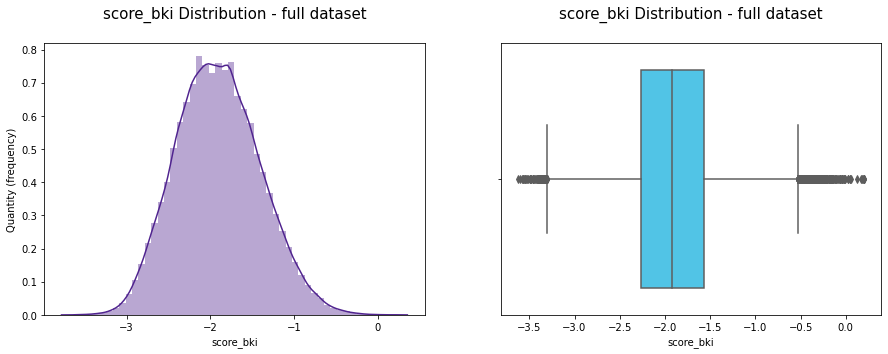

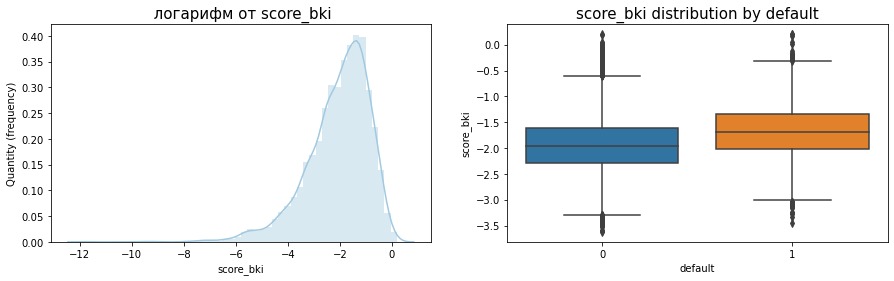

''

In [22]:
show_IQR(df, 'score_bki', 50, 'default', df_train)

Q1: 20000.0
Q3: 48000.0
IQR: 28000.0 
Граница выбросов: [-22000.0, 90000.0]
Пропущено значений: 0


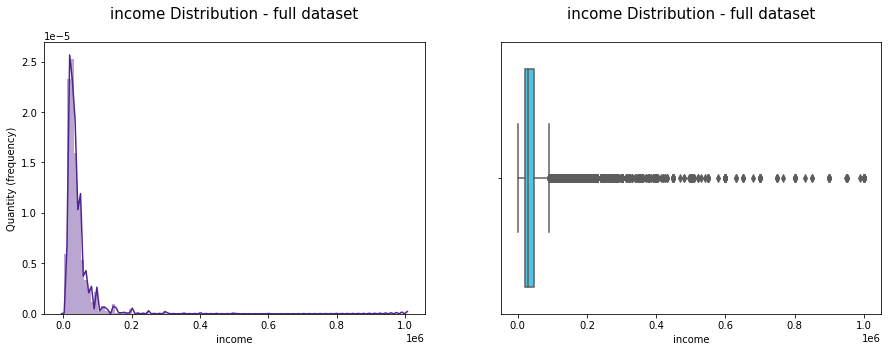

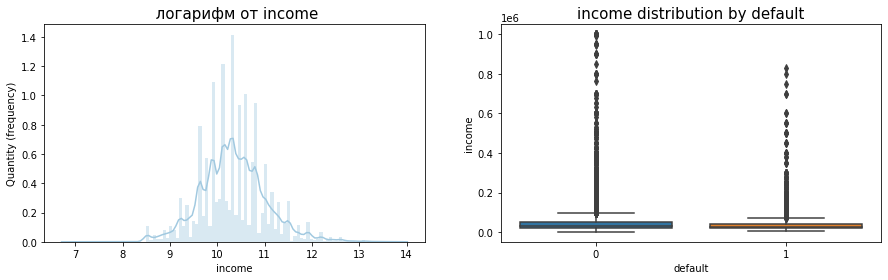

''

In [23]:
show_IQR(df, 'income', 100, 'default', df_train)

Q1: 50.0
Q3: 60.0
IQR: 10.0 
Граница выбросов: [35.0, 75.0]
Пропущено значений: 0


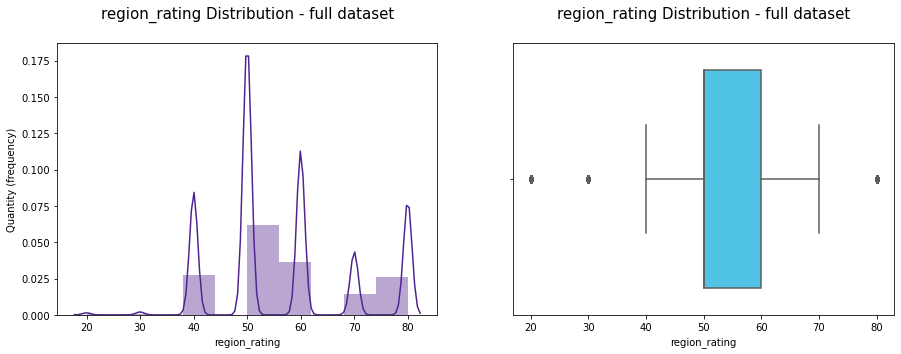

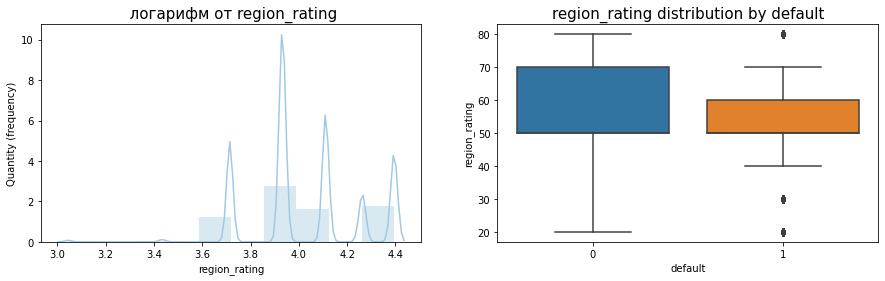

''

In [24]:
# хоть рейтинг региона и не числовое поле, но посмотрим на его распределение как будто это число.
show_IQR(df, 'region_rating', 10, 'default', df_train)

Q1: 1.0
Q3: 4.0
IQR: 3.0 
Граница выбросов: [-3.5, 8.5]
Пропущено значений: 0


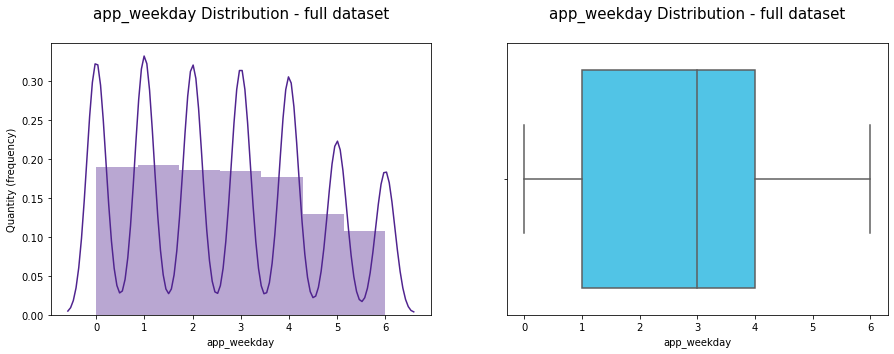

''

In [25]:
show_IQR(df, 'app_weekday', 7)

Q1: 33.0
Q3: 89.0
IQR: 56.0 
Граница выбросов: [-51.0, 173.0]
Пропущено значений: 0


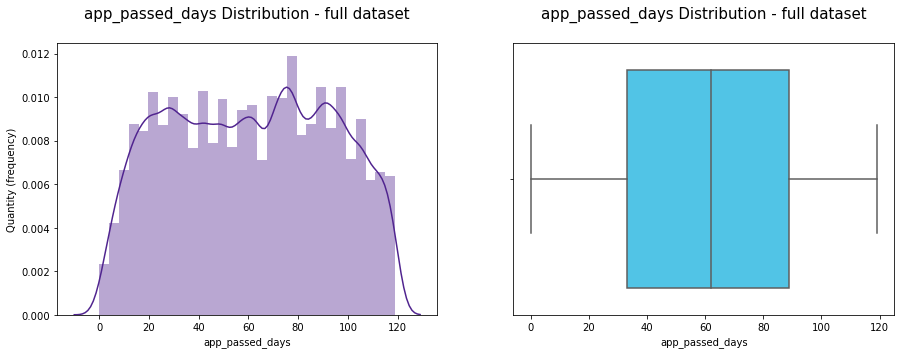

''

In [26]:
show_IQR(df, 'app_passed_days', 30)

#### Корреляция между числовыми признаками

In [27]:
# матрица корреляции численных признаков
df[num_cols].corr()

age  decline_app_cnt  bki_request_cnt  score_bki  \
age              1.000000        -0.111454         0.046975  -0.104682   
decline_app_cnt -0.111454         1.000000         0.159927   0.187869   
bki_request_cnt  0.046975         0.159927         1.000000   0.157451   
score_bki       -0.104682         0.187869         0.157451   1.000000   
income          -0.018664        -0.022241         0.080475  -0.011721   
app_weekday     -0.008631         0.007461         0.011943  -0.001028   
app_passed_days  0.015831        -0.021489        -0.027610  -0.061969   

                   income  app_weekday  app_passed_days  
age             -0.018664    -0.008631         0.015831  
decline_app_cnt -0.022241     0.007461        -0.021489  
bki_request_cnt  0.080475     0.011943        -0.027610  
score_bki       -0.011721    -0.001028        -0.061969  
income           1.000000    -0.020900        -0.002364  
app_weekday     -0.020900     1.000000        -0.038162  
app_passed_days -0.002364    -0.038162         1.000000

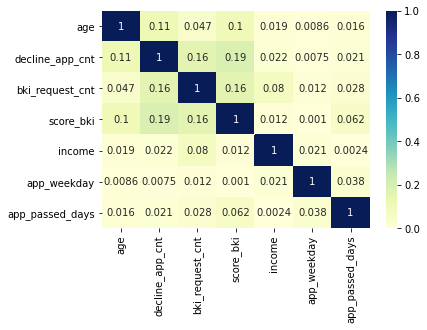

In [28]:
sns.heatmap(df[num_cols].corr().abs(), annot=True, vmin=0, vmax=1, cmap="YlGnBu")

Корреляция между числовыми признаками отсутствует

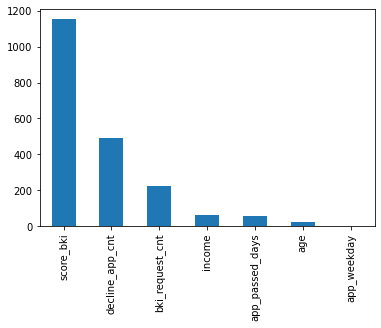

In [29]:
# проранжируем значимость числовых признаков
imp_num = pd.Series(f_classif(df[num_cols], df["default"])[0], index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")
# видимо, поля app_weekday, age app_passed_says можно удалить т.к. они незначительно влияют на целевую переменную

In [30]:
# поля age, income, decline_app_cnt, bki_request_cnt - 
# заметное смещение распределение - после создания кросс-признаков - прологарифмируем признаки для выравнивания распределения

# df['age'] = np.log(df['age'])
# df['income'] = np.log(df['income'])
# df['decline_app_cnt'] = np.log(df['decline_app_cnt']+1)
# df['bki_request_cnt'] = np.log(df['bki_request_cnt']+1)
df = df.drop(['app_date'], axis=1)

### Education,  ординарные признаки
Образование - это ординарный признак, т.к. есть увеличение уровня образования

In [31]:
df["education"].unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan], dtype=object)

In [32]:
df["education"].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [33]:
print(f'Пустых значений: {df["education"].isna().sum()}, ' +
      f'это {100*df["education"].isna().sum() / len(df):0.2f}% от общего количества строк.')

Пустых значений: 478, это 0.43% от общего количества строк.


Посмотрим, какое образование является модой

In [34]:
df["education"].mode()[0]

'SCH'

т.е. школьное образование встречается чаще всего (является модой). 
Для проверки, посмотрим, какое образование является модой в тестовой и тренировочной выборках.

In [35]:
df_train["education"].mode()[0]

'SCH'

In [36]:
df_test["education"].mode()[0]

'SCH'

т.к. и в тренировочной и в тестовой выборках школьное образование является модой, то заполним этим значением пропуски

In [37]:
# заполним пропуски значением, которое встречается чаще всего
df["education"].fillna('SCH', inplace=True)

##### заменяем значения признака образование на числовые значения в порядке возрастания уровня образования

In [38]:
# уровни образования по возрастанию
education_grades = ["SCH", "UGR", "GRD", "PGR", "ACD"]

In [39]:
# заменяем значения признака образование на числовые значения в порядке возрастания уровня образования
df["education"] = OrdinalEncoder(categories=[education_grades]).fit_transform(df[["education"]]).astype(int)

In [40]:
# проверяем
df["education"].value_counts()

0    58476
2    34768
1    14748
3     1865
4      291
Name: education, dtype: int64

##### аналогично заменяем региональный рейтинг, т.к. это ординарный признак

In [41]:
df["region_rating"].value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

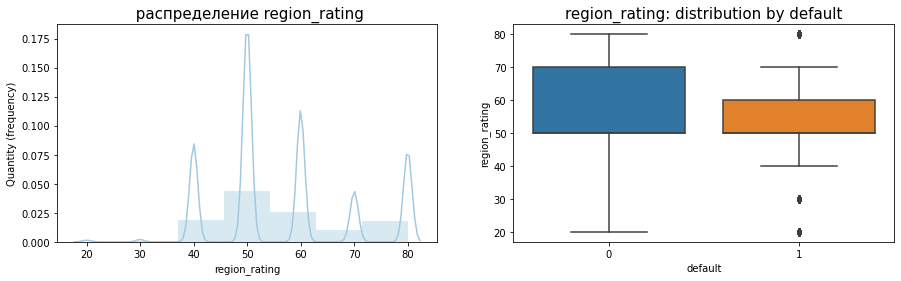

In [42]:
# гистограмма распределения: 
plt.figure(figsize=(15, 4))
plt.subplot(121)
sns.distplot(df['region_rating'].values, bins=7, color='#a1c9e0')
plt.title(' распределение region_rating', fontsize=15)
plt.xlabel('region_rating')
plt.ylabel('Quantity (frequency)')
        
# boxplot: распределение признака по целевой переменной
plt.subplot(122)
sns.boxplot(x=df_train['default'], y=df_train['region_rating'])
plt.title('region_rating: distribution by default', fontsize=15)
plt.xlabel('default')
plt.ylabel('region_rating')
plt.show()

In [43]:
regional_ratings = sorted(df["region_rating"].unique().tolist())
df["region_rating"] = OrdinalEncoder(categories=[regional_ratings]).fit_transform(df[["region_rating"]]).astype(int)

In [44]:
# проверяем
df["region_rating"].value_counts()

3    40981
4    23999
2    17947
6    17170
5     9304
1      434
0      313
Name: region_rating, dtype: int64

### бинарные и категориальные признаки

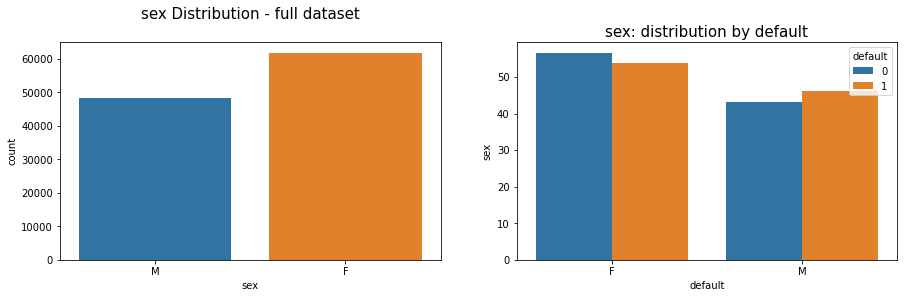

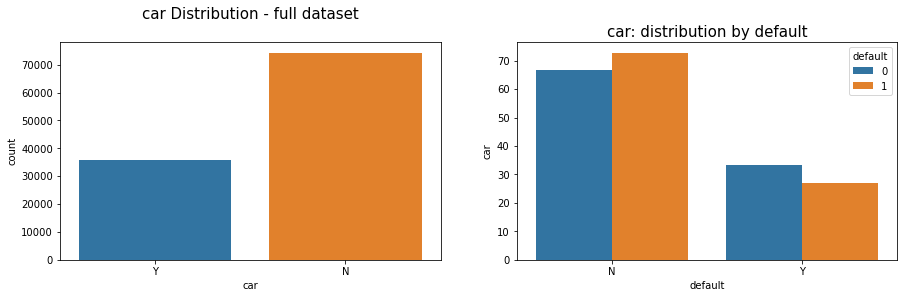

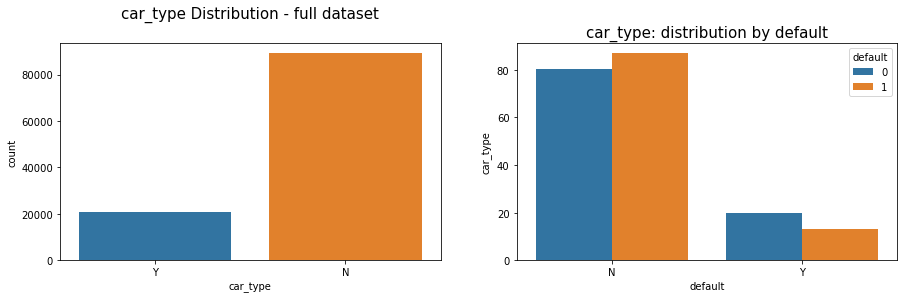

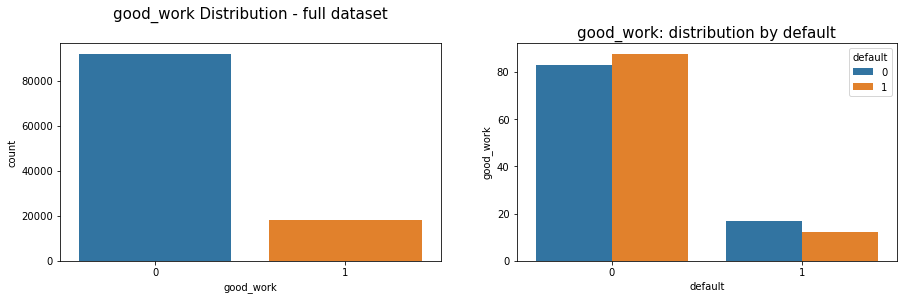

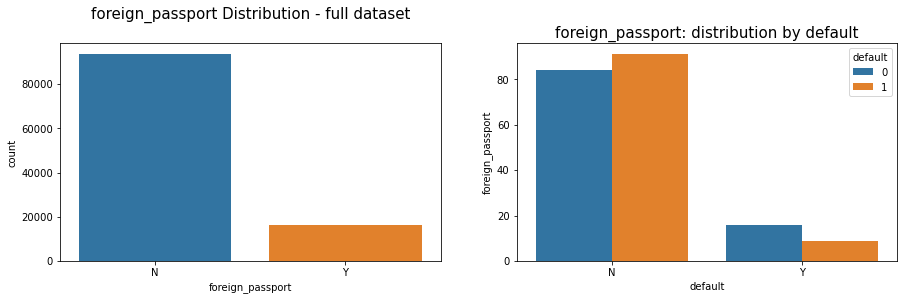

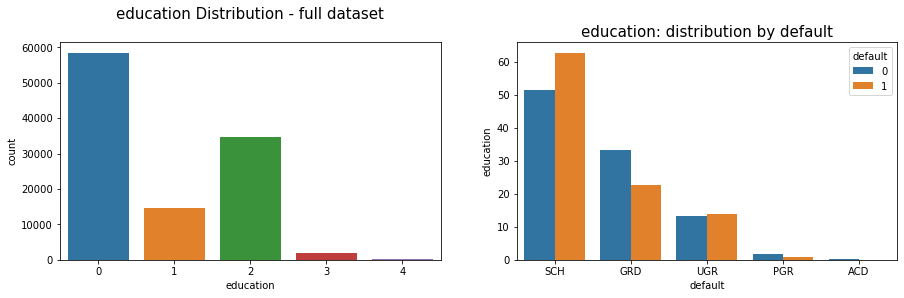

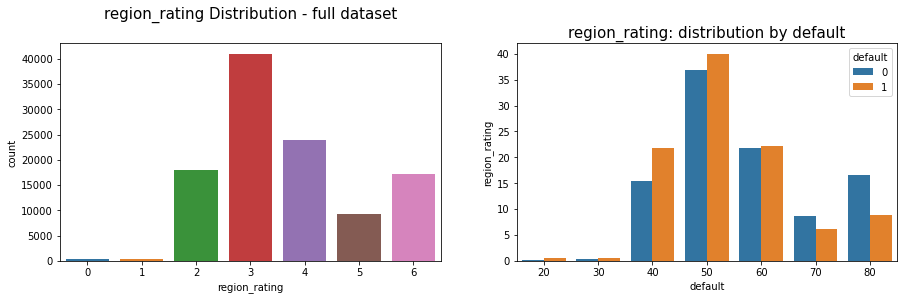

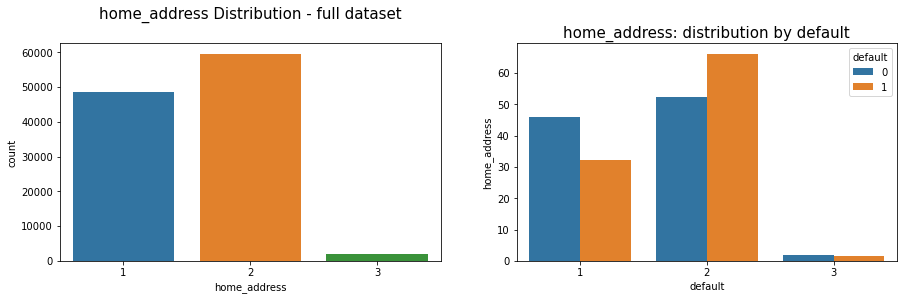

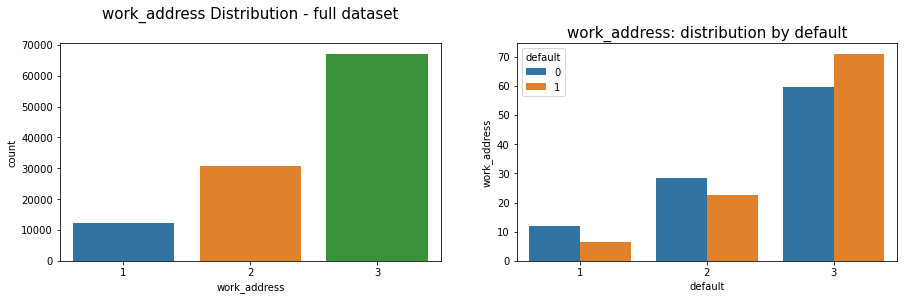

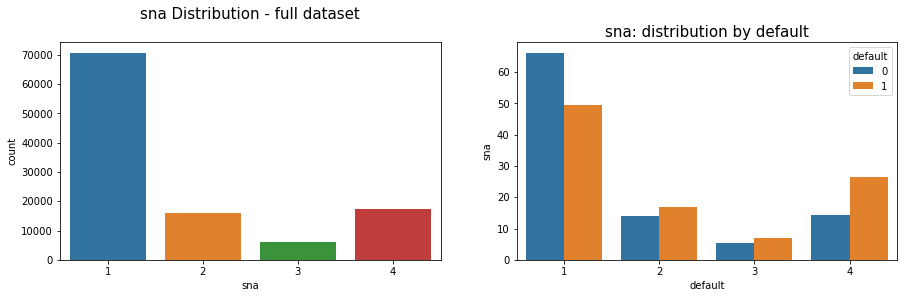

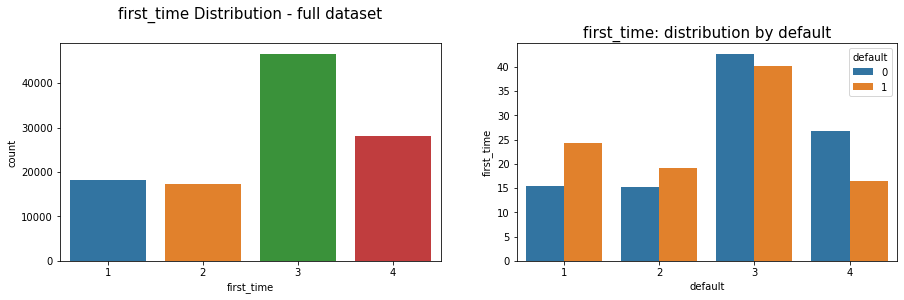

In [45]:
# посмотрим на нечисловые признаки на гистограммах по всему набору данных и в разбивке по 
for column_name in bin_cols + cat_cols:
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    # countplot: распределение признака в полном наборе данных
    sns.countplot(df[column_name].values)
    plt.title(column_name + ' Distribution - full dataset\n', fontsize=15)
    plt.xlabel(column_name)
        
    # barplot: распределение признака по целевой переменной
    plt.subplot(122)
    col_df = df_train[column_name].groupby(df_train["default"]).value_counts(normalize=True).rename("percent").reset_index()
    col_df["percent"] *= 100
    sns.barplot(x=column_name, y="percent", hue="default", data=col_df)
    plt.title(column_name + ': distribution by default', fontsize=15)
    plt.xlabel('default')
    plt.ylabel(column_name)
    plt.show()

Чуть позже оценим полезность каждого из признака для модели.

#### Кодируем бинарные признаки

In [46]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [47]:
# Проверяем
for col_name in bin_cols:
    print(col_name, df[col_name].unique())

sex [1 0]
car [1 0]
car_type [1 0]
good_work [0 1]
foreign_passport [0 1]


#### Кодируем категориальные признаки

In [48]:
df = pd.get_dummies(df, columns=cat_cols)

In [49]:
df.sample(5)

client_id  sex  age  car  car_type  decline_app_cnt  good_work  \
568        78526    0   52    0         0                0          0   
17744      70919    0   28    1         1                0          0   
10904      79970    0   30    0         0                0          0   
13133      26553    1   55    0         0                2          0   
5641       32778    0   34    0         0                0          0   

       score_bki  bki_request_cnt  income  foreign_passport  default  \
568    -1.962578                6   15000                 0        0   
17744  -1.631082                4   30000                 0        0   
10904  -2.421060                2   25000                 0        0   
13133  -1.645997                1   25000                 0        0   
5641   -1.184540                3   20000                 0        0   

       is_train  app_weekday  app_passed_days  education_0  education_1  \
568        True            2               84            0            0   
17744      True            2               77            1            0   
10904      True            4               86            1            0   
13133      True            6               32            0            0   
5641       True            6               39            1            0   

       education_2  education_3  education_4  region_rating_0  \
568              1            0            0                0   
17744            0            0            0                0   
10904            0            0            0                0   
13133            1            0            0                0   
5641             0            0            0                0   

       region_rating_1  region_rating_2  region_rating_3  region_rating_4  \
568                  0                0                0                1   
17744                0                0                1                0   
10904                0                1                0                0   
13133                0                0                1                0   
5641                 0                0                1                0   

       region_rating_5  region_rating_6  home_address_1  home_address_2  \
568                  0                0               1               0   
17744                0                0               0               1   
10904                0                0               1               0   
13133                0                0               1               0   
5641                 0                0               0               1   

       home_address_3  work_address_1  work_address_2  work_address_3  sna_1  \
568                 0               0               1               0      1   
17744               0               0               0               1      0   
10904               0               0               1               0      0   
13133               0               0               0               1      1   
5641                0               0               0               1      1   

       sna_2  sna_3  sna_4  first_time_1  first_time_2  first_time_3  \
568        0      0      0             0             1             0   
17744      0      1      0             0             0             1   
10904      1      0      0             1             0             0   
13133      0      0      0             1             0             0   
5641       0      0      0             0             0             1   

       first_time_4  
568               0  
17744             0  
10904             0  
13133             0  
5641              0

In [50]:
df.shape

(110148, 41)

### Polynomial (Cross) Features
создадим новые данные из числовых признаков

In [51]:
poly = PolynomialFeatures()
# генерируем новые признаки
new_features = poly.fit_transform(df[num_cols].values)
new_features_df = pd.DataFrame(new_features)

# добавляем новые столбцы в наш набор данных
df = pd.concat([df, new_features_df], axis=1)

In [52]:
# проверяем
df.sample(5)

client_id  sex  age  car  car_type  decline_app_cnt  good_work  \
41653       18427    1   30    0         0                0          0   
23726       38927    0   51    0         0                0          0   
78369       19496    0   54    1         0                0          0   
107427      39922    0   38    1         1                0          1   
30794      100055    0   32    0         0                0          0   

        score_bki  bki_request_cnt  income  foreign_passport  default  \
41653   -1.932931                2   35000                 0        0   
23726   -2.059619                1   29000                 0        0   
78369   -2.158458                2   70000                 0       -1   
107427  -2.224347                3   40000                 1       -1   
30794   -2.208295                2   57000                 1        0   

        is_train  app_weekday  app_passed_days  education_0  education_1  \
41653       True            5               24            1            0   
23726       True            5               45            1            0   
78369      False            0               26            0            0   
107427     False            6               46            1            0   
30794       True            3              106            0            0   

        education_2  education_3  education_4  region_rating_0  \
41653             0            0            0                0   
23726             0            0            0                0   
78369             1            0            0                0   
107427            0            0            0                0   
30794             0            1            0                0   

        region_rating_1  region_rating_2  region_rating_3  region_rating_4  \
41653                 0                1                0                0   
23726                 0                0                0                1   
78369                 0                0                0                1   
107427                0                0                0                0   
30794                 0                0                0                0   

        ...          11         12     13      14   15   16   17   18   19  \
41653   ...  -57.987919  1050000.0  150.0   720.0  0.0  0.0 -0.0  0.0  0.0   
23726   ... -105.040576  1479000.0  255.0  2295.0  0.0  0.0 -0.0  0.0  0.0   
78369   ... -116.556731  3780000.0    0.0  1404.0  0.0  0.0 -0.0  0.0  0.0   
107427  ...  -84.525188  1520000.0  228.0  1748.0  0.0  0.0 -0.0  0.0  0.0   
30794   ...  -70.665435  1824000.0   96.0  3392.0  0.0  0.0 -0.0  0.0  0.0   

         20   21        22        23    24     25        26            27  \
41653   0.0  4.0 -3.865861   70000.0  10.0   48.0  3.736221  -67652.57240   
23726   0.0  1.0 -2.059619   29000.0   5.0   45.0  4.242031  -59728.95477   
78369   0.0  4.0 -4.316916  140000.0   0.0   52.0  4.658941 -151092.05860   
107427  0.0  9.0 -6.673041  120000.0  18.0  138.0  4.947720  -88973.88160   
30794   0.0  4.0 -4.416590  114000.0   6.0  212.0  4.876566 -125872.80645   

               28          29            30        31         32    33     34  \
41653   -9.664653  -46.390335  1.225000e+09  175000.0   840000.0  25.0  120.0   
23726  -10.298096  -92.682861  8.410000e+08  145000.0  1305000.0  25.0  225.0   
78369   -0.000000  -56.119907  4.900000e+09       0.0  1820000.0   0.0    0.0   
107427 -13.346082 -102.319964  1.600000e+09  240000.0  1840000.0  36.0  276.0   
30794   -6.624885 -234.079254  3.249000e+09  171000.0  6042000.0   9.0  318.0   

             35  
41653     576.0  
23726    2025.0  
78369     676.0  
107427   2116.0  
30794   11236.0  

[5 rows x 77 columns]

In [53]:
df.shape

(110148, 77)

наименование новых столбцов соберем в новом списке, позже добавим их к числовым

In [54]:
poly_cols = []
for i in range(0, 36):
    poly_cols.append(i)
num_poly_cols = num_cols+poly_cols

#### логирифмируем числовые поля с сильно смещенными распределениями

In [55]:
# поля: age, income, decline_app_cnt, bki_request_cnt  
# обладают заметным смещением распределения
# прологарифмируем признаки для выравнивания распределения

df['age'] = np.log(df['age'])
df['income'] = np.log(df['income'])
df['decline_app_cnt'] = np.log(df['decline_app_cnt']+1)
df['bki_request_cnt'] = np.log(df['bki_request_cnt']+1)

### Анализ важности признаков

In [56]:
# сначала выявим численные признаки, которые являются существенными для нашей модели
temp_data = df[df['is_train']]
imp_num = pd.Series(f_classif(temp_data[num_poly_cols], temp_data['default'])[0], index = num_poly_cols)
imp_num.sort_values(ascending=False)

score_bki          2341.599450
4                  2341.599450
26                 2120.791057
11                 1210.356734
decline_app_cnt    1152.937317
2                   966.206975
9                   879.859393
29                  837.695301
19                  693.115910
17                  636.665916
20                  599.042739
bki_request_cnt     457.591760
3                   454.555786
16                  442.729207
27                  378.278264
10                  339.657261
28                  238.670261
18                  230.064658
24                  217.121702
income              214.786326
21                  210.909170
25                  177.249162
15                  168.132187
32                  150.557639
14                  143.441942
35                  126.069646
12                  117.204312
5                   116.798014
7                   114.576824
app_passed_days     114.576824
31                   65.215128
22                   54.404839
age     

In [57]:
# считаем, что только первые 80% процентов полей являются важными, остальные 20% - отбросим
signf_num_cols = list(imp_num.sort_values(ascending=False).keys()[:int(len(imp_num)*0.8)])

#### аналогично, выявим существенные категориальные и бинарные признаки

In [58]:
bin_cat_cols = list(df.columns)
for x in num_poly_cols:
    bin_cat_cols.remove(x)
    
# удалим лишние столбцы
bin_cat_cols.remove('client_id')
bin_cat_cols.remove('default')
bin_cat_cols.remove('is_train')

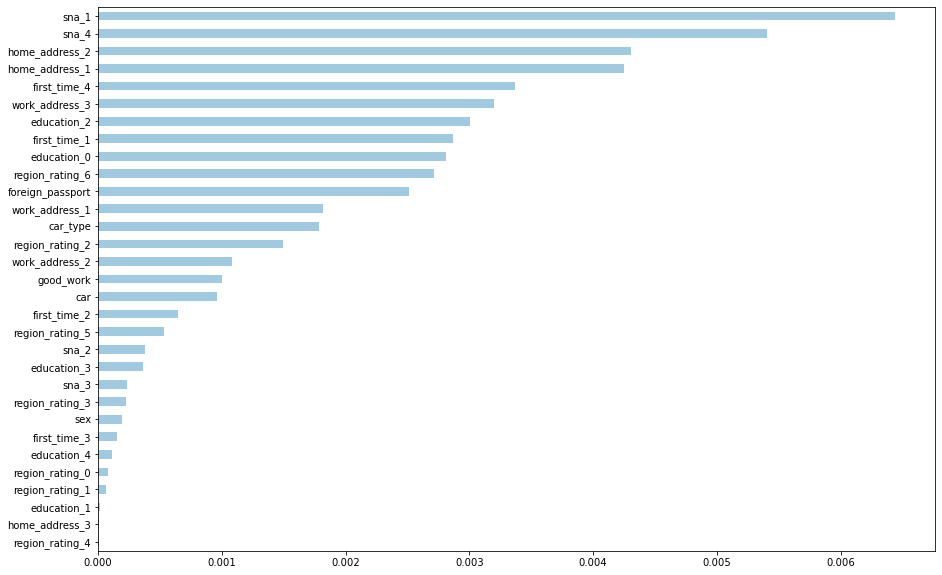

In [59]:
temp_data = df[df['is_train']==1]
imp_cat = pd.Series(mutual_info_classif(temp_data[bin_cat_cols], temp_data['default'],
                                     discrete_features =True), index = bin_cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh',figsize=(15,10), color='#a1c9e0')

In [60]:
# отбросим нижние 20% данных, оставим тоьлко 80%
list(imp_cat.sort_values(ascending=False).keys()[:int(len(imp_cat)*0.8)])

['sna_1',
 'sna_4',
 'home_address_2',
 'home_address_1',
 'first_time_4',
 'work_address_3',
 'education_2',
 'first_time_1',
 'education_0',
 'region_rating_6',
 'foreign_passport',
 'work_address_1',
 'car_type',
 'region_rating_2',
 'work_address_2',
 'good_work',
 'car',
 'first_time_2',
 'region_rating_5',
 'sna_2',
 'education_3',
 'sna_3',
 'region_rating_3',
 'sex']

In [61]:
sorted_list = (list(imp_cat.sort_values(ascending=False).keys()))

In [62]:
# проверяем, что все поля статистически значимы
for col in sorted_list:
    get_stat_dif(temp_data, col, 'default')

обнаружена статистическая значимость измерения:  sna_1
обнаружена статистическая значимость измерения:  sna_4
обнаружена статистическая значимость измерения:  home_address_2
обнаружена статистическая значимость измерения:  home_address_1
обнаружена статистическая значимость измерения:  first_time_4
обнаружена статистическая значимость измерения:  work_address_3
обнаружена статистическая значимость измерения:  education_2
обнаружена статистическая значимость измерения:  first_time_1
обнаружена статистическая значимость измерения:  education_0
обнаружена статистическая значимость измерения:  region_rating_6
обнаружена статистическая значимость измерения:  foreign_passport
обнаружена статистическая значимость измерения:  work_address_1
обнаружена статистическая значимость измерения:  car_type
обнаружена статистическая значимость измерения:  region_rating_2
обнаружена статистическая значимость измерения:  work_address_2
обнаружена статистическая значимость измерения:  good_work
обнаружена 

In [63]:
signf_cols = signf_num_cols + sorted_list
signf_var_for_model = ['client_id'] + signf_cols + ['is_train'] + ['default']
df = df[signf_var_for_model]

## 6. Подготовка набора для машинного обучения

In [64]:
# разделяем набор данных на обучающую и тестовую выборки
train_df = df[df['is_train']]  # выборка для обучения
test_df = df[~df['is_train']]  # выборка для финального тестирования

#### проводим стандартизацию

In [65]:
# проводим стандартизацию даных для обучающей и тестовых выборок (независимо)
for column in signf_num_cols:
    train_df[column] = scaler_column(train_df, column)

for column in signf_num_cols:
    test_df[column] = scaler_column(test_df, column)

data = train_df.append(test_df, sort=False).reset_index(drop=True)

#### проверка сбалансированности данных

In [66]:
classes = data['default'].value_counts(ascending=True)
print('пропорция:',classes[0]/classes[1],'(т.к. соотношение меньше, чем 10:1), то дополнительная балансировка не требуется')

пропорция: 6.874413145539906 (т.к. соотношение меньше, чем 10:1), то дополнительная балансировка не требуется


In [67]:
train_df = train_df.drop(['is_train', 'client_id'], axis=1)

y = train_df['default'].values
X = train_df.drop(['default'], axis=1)

# разделяем обучающую выборку на обучающую и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

## 7. Машинное обучение, логистическая регрессия

In [68]:
# собственно, машинное обучение..
logreg = LogisticRegression(random_state=RANDOM_SEED,max_iter=1000)

logreg.fit(X_train, y_train)

y_pred_proba = logreg.predict_proba(X_valid)[:, 1]
y_pred = logreg.predict(X_valid)

In [69]:
show_metrics(y_valid, y_pred, y_pred_proba)

accuracy score =  0.875
precision score =  0.439
recall score =  0.024
f1 score =  0.045
roc auc score =  0.744


(0.875, 0.439, 0.024, 0.045, 0.744)

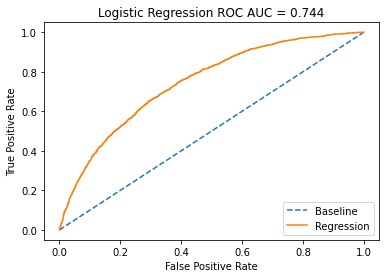

0.7443798066503416

In [70]:
roc_auc_plot(y_valid, y_pred_proba)

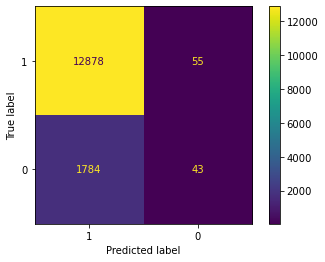

In [71]:
confusion_matrix_plot(y_valid, y_pred)

#### настройка гиперпараметров

In [72]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 3593.813663804626


In [73]:
final_lr_model = LogisticRegression(
    penalty=best_model.best_estimator_.get_params()['penalty'],
    C=best_model.best_estimator_.get_params()['C'],
    max_iter=1000)
final_lr_model.fit(X_train, y_train)

LogisticRegression(C=3593.813663804626, max_iter=1000)

In [74]:
probs = final_lr_model.predict_proba(X_valid)
y_pred_probs = probs[:,1]
y_pred = final_lr_model.predict(X_valid)

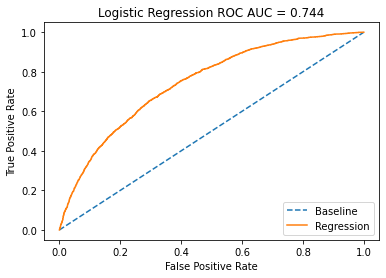

0.7443562335138816

In [75]:
roc_auc_plot(y_valid, y_pred_probs)

In [76]:
show_metrics(y_valid, y_pred, y_pred_probs)

accuracy score =  0.875
precision score =  0.444
recall score =  0.024
f1 score =  0.046
roc auc score =  0.744


(0.875, 0.444, 0.024, 0.046, 0.744)

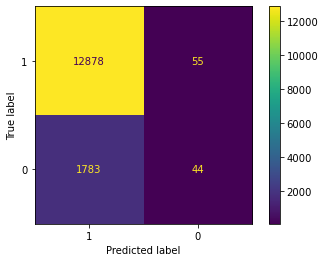

In [77]:
confusion_matrix_plot(y_valid, y_pred)

Модель обучена, метрики не плохие, формируем прогноз тестовой выборки и отправляем данные на проверку.

## 8. Прогноз тестовой выборки

In [89]:
# проверим корректность..
X_test.shape

(36349, 65)

In [90]:
# готовим данные
test_client_id = df_test.client_id
X_test = test_df.drop(['is_train', 'client_id', 'default'], axis=1)

In [81]:
# получаем прогноз
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

## 9. Submission

In [87]:
submission = pd.DataFrame({'client_id': test_client_id,
                              'default': y_pred_prob})
submission.to_csv('submission.csv', index=False)

submission.sample(5)

client_id   default
33014       9190  0.132123
8533       12871  0.064697
31013      45995  0.068249
17640       6922  0.134725
11151      22465  0.037788